<img src="https://cs7.pikabu.ru/post_img/2014/03/10/4/1394427243_1353289544.jpg" height="400" width="400"> 

# <center> ML для маркетинга. <br>  <br> Cюжетная арка 2: отток и привлечение </center>

В этом семестре мы с вами пройдём через несколько сюжетных арок. Второй такой аркой будут отток и привлечение. Им будет посвящена вторая серия из семинаров и домашек. 

В домашке мы поработаем с немного другой задачей классификации. Она будет связана с оттоком и превлечением клиентов. Будет весело __(но это неточно)__! 

## Задача:

В наших руках оказались [данные со статистикой скачки мобильных приложений из Appstore.](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps/home) Предположим, что мы хотим запилить своё собственное приложение и заработать на нём денег. Чтобы успешно монетизироваться, нам нужно много пользователей. Возникает задача их привлечения и последущего удержания.

Для того, чтобы наше приложение привлекло много пользователей, хочется, чтобы у него были высокие рейтинги. В этой тетрадке мы попробуем обучить модель, которая будет предсказывать рейтинг приложения по его параметрам. С помощью этой модели мы сможем посмотреть на то, на какие факторы имеет смысл обращать внимание в первую очередь, а также мы посмотрим как именно долгосрочный рейтиг (удержание) отличается от краткосрочного (привлечение). 


#  Часть I (Братство предобработки) 

In [1]:
# Как обычно, для начала подгружаем нужные нам пакеты
import pandas as pd    # пакет для работы с таблицами 
import numpy as np     # пакет для работы с матрицами 

# пакеты для картиночек 
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

Наш набор данных содержит более $7000$ наблюдений о мобильных приложениях под IOS. 

__Описание переменных:__

* `id` - идентификатор приложения;
* `track_name` - название приложения;
* `size_bytes` - размер приложения в байтах;
* `currency` - тип валюты, в которой платят за приложение;
* `price` - цена приложения;
* `rating_count_tot` - число проголосовавших юзеров;
* `rating_count_ver` - число проголосовавших юзеров (для текущей версии приложения);
* `user_rating` - среднее значение рейтинга для всех версий;
* `user_rating_ver` - среднее значение рейтинга для текущей версии;
* `ver` - код последней версии;
* `cont_rating` - возрастные ограничения;
* `prime_genre` - жанр;
* `sup_devices.num` - число поддерживающих устройств;
* `ipadSc_urls.num` - число скриншотов с примерами;
* `lang.num` - число поддерживаемых языков;
* `vpp_lic` - есть ли лицензия VPP;
* `app_desc` - описание приложения. 


In [2]:
df = pd.read_csv('apple.csv', sep = '\t')

df.drop('id', axis=1, inplace=True) # выбрасываю техническую колонку с id 
 
print(df.shape)
df.head()

(7197, 16)


,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc
0,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,Let Evernote change the way you organize your ...
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,Download the most popular free weather app pow...
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,The eBay app is the best way to find anything ...
4,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,On more than 250 million devices around the wo...


__[1] Целевая переменная__ 

На основе этих данных можно посмотреть какими характеристиками должно обладать приложение, привлекающее людей и сделать своё приложение так, чтобы его рейтинги были максимально возможными. 

Целевой переменной для данной задачи будет рейтинг приложения. Нам хотелось бы, чтобы рейтинг нашего приложения был как можно выше. Будем считать, что нас устроит рейтинг $>4$. Разделим все приложения на хорошие и плохие и будем решать задачу классификации. Конечно можно было бы решать и задачу регрессии, но нам не нужна излишняя детализация. Какая разница, оценка у нашего приложени $2.6$ или $2.7$? Главное, что оно не привлекает пользователя. Новую целевую переменную запишите в колонку `is_popular`.

In [3]:
df['is_popular'] = (df['user_rating'] > 4).astype(int)

__[1] Размер приложухи__

В колонке `rating_count_tot` находится число людей, которое поставило оценку приложению. Давайте разделим все приложения, которые у нас есть на два типа: молодые (у них мало оценок) и старые (у них есть уже много оценок). Создайте переменную `is_small`. Запишите туда $1$, если у приложения меньше $200$ оценок. 

In [4]:
df['is_small'] = (df['rating_count_tot'] < 200).astype(int)

__[1] Рейтинг и размер__  

Посотрим насколько сильно различается распределение оценок на большом и маленьком числе пользователей. Для этого построим две гистограммы. Одну для маленьких пользователей, вторую для больших.  

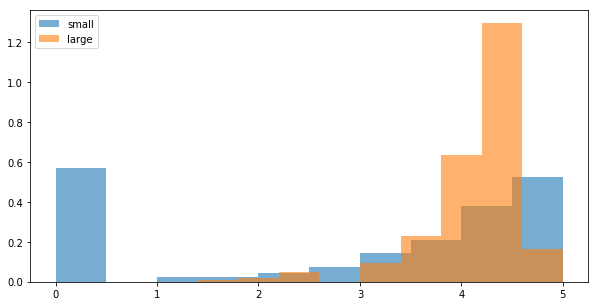

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(df[df['is_small'] == 1]['user_rating'], alpha = 0.6, density=True, label="small")

# Ваш код для больших приложений
plt.hist(df[df['is_small'] == 0]['user_rating'], alpha = 0.6, density=True, label="large")

plt.legend()
plt.show()

Проинтерпретируйте получившуюся картинку.  В чём заключается разница между большими приложениями и маленькими? 


__Ответ:__ 

* У приложений, получивших мало отзывов очень много нулей. Возможно, что это связано с тем, что никто не поставил на эти приложения оценку. Это можно проверить. 

In [6]:
df[(df['is_small']  == 1)&(df['user_rating'] == 0)].rating_count_tot.value_counts()

0    929
Name: rating_count_tot, dtype: int64

* Другое наблюдение: у больших приложений намного меньше пятёрок. Возможно, что пока у маленького приложения мало оценок, его легче накрутить на пять звёзд. 
* У больших приложений намного меньше разброс в оценках. Это объясняется двумя основными факторами. __Во-первых,__ чем больше пользователей поставило оценку, тем меньше влияет оценка каждого из них на конечный рейтинг. Из-за этого у оценок оказывается более маленький разброс. __Во-вторых,__ популярные приложения как правило разработаны и поддерживаются компаниями в целях получения прибыли, а не студентами ради развлечения, как следствие - у популярных приложений обычно достойное качество.

Удалите колонки `user_rating`, `user_rating_ver`, `rating_count_ver`, `rating_count_tot`.

In [7]:
df = df.drop(['user_rating', 'user_rating_ver', 'rating_count_ver', 'rating_count_tot'], axis=1)

__[1]__ Есть ли среди классов "популярные приложения" и "непопулярные приложения" дисбаланс среди мелких приложух? А среди больших? 

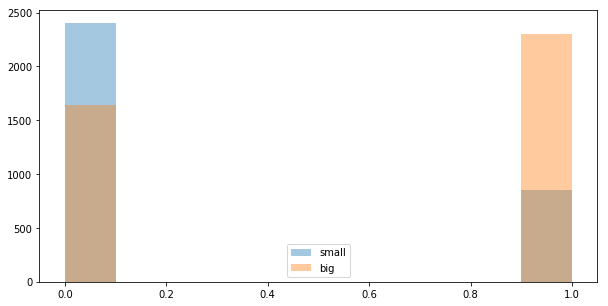

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(df[df['is_small'] == 1]['is_popular'], alpha = 0.4, label="small")
plt.hist(df[df['is_small'] == 0]['is_popular'], alpha = 0.4, label="big")

plt.legend()
plt.show()

Дисбаланс присутсвует в обоих случаях, для малениких приложении примерно в $3$ раза в сторону низкой оценки, для больших примерно в $1.5$ в сторону высокой оценки.

__[2] Действительные переменные__

Выделите в отдельный список действительные переменные. Проанализируйте, какие для них возникают проблемы. Исправьте все эти проблемы. Если вы видите, что для какой-то из переменных нужно сварить дополнительную фичу, как это произошло на семинаре, сделайте это прямо в этом пункте. 

__Возможные проблемы:__ 

* Пропуски в данных $\Rightarrow$ надо бы заполнить 
* Выбросы в данных $\Rightarrow$  надо предобработать 
* Разные единицы измерения $\Rightarrow$ решим потом эту проблему скалированием позже, при моделировании.

In [9]:
# ipadSc_urls.num можно взять и в категориальные переменные.
var_real = ['lang.num', 'ipadSc_urls.num', 'sup_devices.num', 'price', 'size_bytes']

In [10]:
# Пропусков нет!
df[var_real].isnull().sum()

lang.num           0
ipadSc_urls.num    0
sup_devices.num    0
price              0
size_bytes         0
dtype: int64

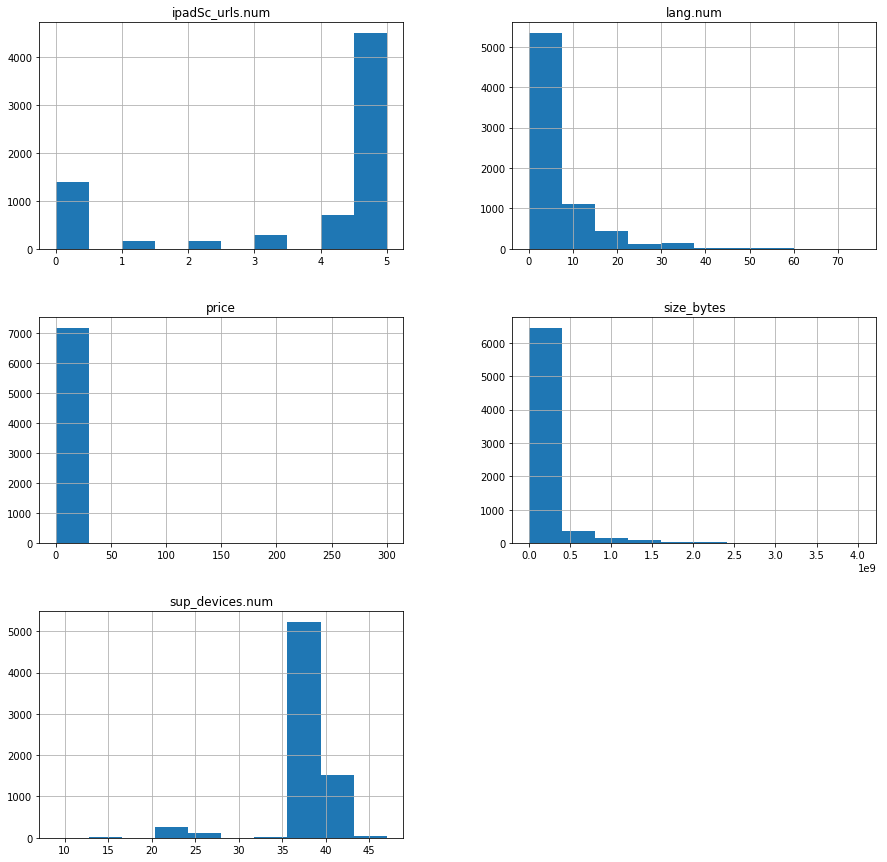

In [11]:
df[var_real].hist(figsize=(15,15));

По гистограммам видно, что у цен довольно большой хвост. Скорее всего, это связано с тем, что в маркете очень м ного бесплатных приложений. Имеет смысл выделить всех таких ребят в отдельную дамми-переменную. 

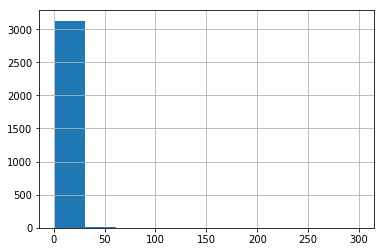

In [12]:
df['is_for_free'] =  (df['price'] == 0).astype(int)

df[df['price'] > 0]['price'].hist()

От длинного хвоста это нас не избавит. Придётся переменную дополнительно прологорифмировать. Также имеет смысл сгладить размеры приложений, хоть там хвост и не такой огромный. 

In [13]:
df['price'] = df['price'].apply(lambda w: np.log(w + 1))
df['size_bytes'] = df['size_bytes'].apply(lambda w: np.log(w + 1))

Многие посмотрели на распределение языков и выяснили, что $25\%$ приложений представлены на более, чем $8$ языках. Возможно, если сварить для этих интернациональных приложений специальную дамми,  это поможет нам. 

In [14]:
df['lang.num'].describe()

count    7197.000000
mean        5.434903
std         7.919593
min         0.000000
25%         1.000000
50%         1.000000
75%         8.000000
max        75.000000
Name: lang.num, dtype: float64

In [15]:
df['is_multilingual'] = (df['lang.num'] > 8).astype(int)

__[2] Категориальные переменные__ 

Выделите в отдельный список категориальные переменные. Проанализируйте, какие для них возникают проблемы. Исправьте их. Если вы видите, что для какой-то из переменных нужно сварить дополнительную фичу, как это произошло на семинаре, сделайте это прямо в этом пункте. 

__Важно:__ в колонках `track_name` и `app_desc` находятся текстовые описания и название. Они для каждого наблюдения уникальны. Не надо трогать эти колонки в этом пункте.


__Проблемы:__ 

* Неинформативные категории
* Мелкие категории 
* Пропуски в данных 

In [16]:
# версию не будем включать в категрии, она почти везде уникальная, её выбросим
var_cat = ['currency', 'cont_rating', 'prime_genre', 'vpp_lic']

# Пропусков нет 
df[var_cat].isnull().sum()

currency       0
cont_rating    0
prime_genre    0
vpp_lic        0
dtype: int64

Построим картинку. 

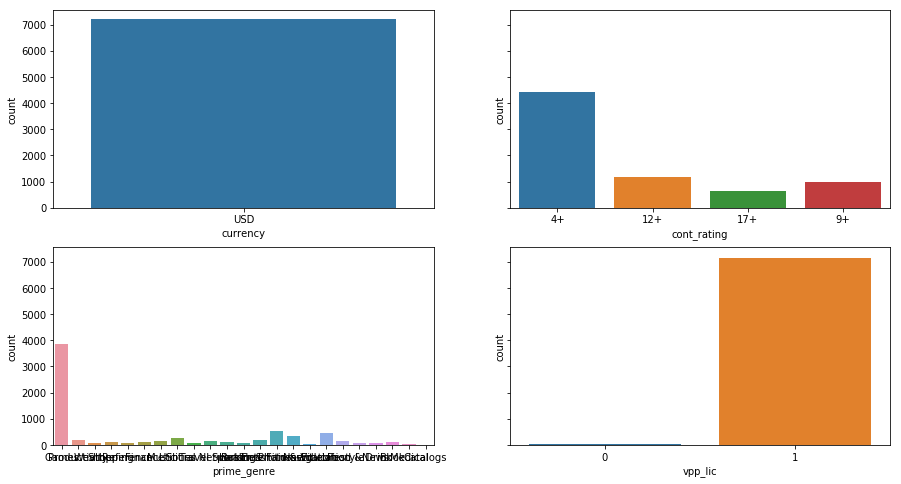

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharey=True)

for i in range(len(var_cat)):
    sns.countplot(x=var_cat[i], data=df, ax=axes[i // 2, i % 2])

Видим, что все приложения поддерживают одну валюту, а также практически все приложения имеют лицензию VPP, поэтому эти две переменные имеет смысл выбросить. 

In [18]:
df.drop(['vpp_lic', 'currency'], axis=1, inplace=True)

Посмотрим как часто в данных встречаются жанры игр. 

In [19]:
df.prime_genre.value_counts()

Games                3862
Entertainment         535
Education             453
Photo & Video         349
Utilities             248
Health & Fitness      180
Productivity          178
Social Networking     167
Lifestyle             144
Music                 138
Shopping              122
Sports                114
Book                  112
Finance               104
Travel                 81
News                   75
Weather                72
Reference              64
Food & Drink           63
Business               57
Navigation             46
Medical                23
Catalogs               10
Name: prime_genre, dtype: int64

Малочисленных категорий не так много. В принципе ими можно при особо большой ленивости пренебречь. Но мы выделим всё, где меньше  $60$ наблюдений в мелкую категорию `another` в качетсве упражнения. 

In [20]:
genre_count = df.prime_genre.value_counts()
small_genre = genre_count[genre_count < 60].index

In [21]:
df['prime_genre'] = df['prime_genre'].apply(lambda w: 'another' if w in small_genre else w)

Посмотрим что осталось в данных. 

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 14 columns):
track_name         7197 non-null object
size_bytes         7197 non-null float64
price              7197 non-null float64
ver                7197 non-null object
cont_rating        7197 non-null object
prime_genre        7197 non-null object
sup_devices.num    7197 non-null int64
ipadSc_urls.num    7197 non-null int64
lang.num           7197 non-null int64
app_desc           7197 non-null object
is_popular         7197 non-null int64
is_small           7197 non-null int64
is_for_free        7197 non-null int64
is_multilingual    7197 non-null int64
dtypes: float64(2), int64(7), object(5)
memory usage: 787.2+ KB


В данных есть несколько текстовых переменных с типом object и версия приложения. Перед тем как делать OHE их надо выбросить. Если вы не делали бонусные пункты, можно было прямо тут сделать это, а после заняться OHE. Мы отложим этот процесс до конца тетрадки.

__[1] Тексты__ 

Пора немного потрогать `track_name` и `app_desc`. Cделайте на их основе новые две переменные:  длина названия и длина описания. Добавьте их в датасет. 

In [23]:
df['len_of_name'] = df['track_name'].apply(len)
df['len_of_desc'] = df['app_desc'].apply(len)

__[Бонусные баллы]__ 

Попробуйте на основе описания и названия приложения придумать какие-нибудь ещё переменные. Возможно, на ваш взгляд важно, что в описании упоминаются какие-то конкретные слова. Какие это могут быть слова? Возможно, из описания можно как-то извлечь информацию о скидках. 

__Важно:__ следите за тем, чтобы получившаяся переменая не оказывалась очень редкой. 

__У вас в работах я нашёл три прикольные идеи.__ Хочу подчеркнуть, что это не мой код, а ваш. 

In [24]:
# Выясняем есть ли в описании приложения информация о скидках

df['there_is_a_discount'] = df['app_desc'].apply(lambda w:
                    True if 'save' in w else False) | df['app_desc'].apply(lambda w:
                    True if '%' in w else False) | df['app_desc'].apply(lambda w:
                    True if 'discount' in w else False) | df['app_desc'].apply(lambda w:
                    True if 'Save' in w else False) | df['app_desc'].apply(lambda w:
                    True if 'Discount' in w else False) | df['app_desc'].apply(lambda w:
                    True if 'SAVE' in w else False)

df['there_is_a_discount'].value_counts()

False    5603
True     1594
Name: there_is_a_discount, dtype: int64

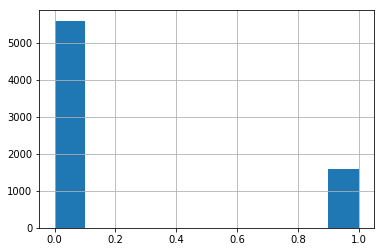

In [25]:
df['there_is_a_discount'] = df['there_is_a_discount'].astype(int)
df['there_is_a_discount'].hist()

Можно еще сделать переменную, которая показывает, у каких приложений оптимальные размер названия(по символам). Насколько я знаю, размер названия приложения - это очень важно. По данным исследований, длина названия не должно превышать $23-24$ знаков.

__Исследование:__  http://icenter.ru/docs/TrialSub_2014-10/29_VMPR_10_%202014.pdf

Смотреть страницы $50-51.$

In [26]:
df['is_short_name'] = (df['len_of_name'] < 25).astype(int)
df['is_short_name'].value_counts()

1    4133
0    3064
Name: is_short_name, dtype: int64

Выбрасываем текстовые переменные и версию. 

In [28]:
df.drop(['track_name', 'app_desc', 'ver'], axis=1, inplace=True)

Две переменные типа `object`, как мы и хотели. 

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 15 columns):
size_bytes             7197 non-null float64
price                  7197 non-null float64
cont_rating            7197 non-null object
prime_genre            7197 non-null object
sup_devices.num        7197 non-null int64
ipadSc_urls.num        7197 non-null int64
lang.num               7197 non-null int64
is_popular             7197 non-null int64
is_small               7197 non-null int64
is_for_free            7197 non-null int64
is_multilingual        7197 non-null int64
len_of_name            7197 non-null int64
len_of_desc            7197 non-null int64
there_is_a_discount    7197 non-null int64
is_short_name          7197 non-null int64
dtypes: float64(2), int64(11), object(2)
memory usage: 843.5+ KB


Можем сделать OHE. 

In [30]:
df = pd.get_dummies(df, drop_first=True, dummy_na=False)
df.shape

(7197, 35)

In [31]:
df.head()

,size_bytes,price,sup_devices.num,ipadSc_urls.num,lang.num,is_popular,is_small,is_for_free,is_multilingual,len_of_name,...,prime_genre_Photo & Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather,prime_genre_another
0,18.428532,1.607436,38,5,10,0,0,0,1,15,...,0,0,0,0,0,0,0,0,0,0
1,18.881761,0.000000,37,5,23,0,0,1,1,25,...,0,1,0,0,0,0,0,0,0,0
2,18.425907,0.000000,37,5,3,0,0,1,0,47,...,0,0,0,0,0,0,0,0,1,0
3,18.671533,0.000000,37,5,9,0,0,1,1,50,...,0,0,0,1,0,0,0,0,0,0
4,18.345681,0.000000,37,5,45,1,0,1,1,5,...,0,0,1,0,0,0,0,0,0,0


In [32]:
df.columns # прост посмотрели на колонки

Index(['size_bytes', 'price', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num',
       'is_popular', 'is_small', 'is_for_free', 'is_multilingual',
       'len_of_name', 'len_of_desc', 'there_is_a_discount', 'is_short_name',
       'cont_rating_17+', 'cont_rating_4+', 'cont_rating_9+',
       'prime_genre_Education', 'prime_genre_Entertainment',
       'prime_genre_Finance', 'prime_genre_Food & Drink', 'prime_genre_Games',
       'prime_genre_Health & Fitness', 'prime_genre_Lifestyle',
       'prime_genre_Music', 'prime_genre_News', 'prime_genre_Photo & Video',
       'prime_genre_Productivity', 'prime_genre_Reference',
       'prime_genre_Shopping', 'prime_genre_Social Networking',
       'prime_genre_Sports', 'prime_genre_Travel', 'prime_genre_Utilities',
       'prime_genre_Weather', 'prime_genre_another'],
      dtype='object')

__[1]__ Осталось разбить выборку на трэйн и тест и сохранить две таблички. В тест возьмите $20 \%$ выборки. 

In [33]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, 
                                     stratify = df['is_popular']) #сбалансировали

In [34]:
df_train['is_popular'].value_counts()/df_train.shape[0]*100 #проверили train

0    56.157721
1    43.842279
Name: is_popular, dtype: float64

In [35]:
df_test['is_popular'].value_counts()/df_test.shape[0]*100 #проверили test

0    56.180556
1    43.819444
Name: is_popular, dtype: float64

In [36]:
df_train.to_csv('apple_train.csv', sep='\t', index=False)
df_test.to_csv('apple_test.csv', sep='\t', index=False)